In [ ]:
import pandas as pd

# Leer el archivo CSV proporcionado
file_path = "/content/VideoComments.csv"
df = pd.read_csv(file_path, encoding='utf-8')

# Mostrar las primeras filas del dataset
df.head(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17924 entries, 0 to 17923
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VideoID     17924 non-null  object
 1   Comentario  17924 non-null  object
 2   Fecha       17924 non-null  object
dtypes: object(3)
memory usage: 420.2+ KB


(       VideoID                                         Comentario  \
 0  2Btx6xU8Aw4  dios mio que risa ghassan... &quot;te cortaste...   
 1  2Btx6xU8Aw4                   el discurso de cynthia es brutal   
 2  2Btx6xU8Aw4  tendría sentido que llevaras un vestido de tu ...   
 3  2Btx6xU8Aw4  Qué pechada a llorar con el discurso de tu her...   
 4  2Btx6xU8Aw4                           No estoy llorando 🥲🥲🥹🥹🥹🥹   
 
                   Fecha  
 0  2024-09-23T12:31:14Z  
 1  2024-09-23T12:28:25Z  
 2  2024-09-23T12:11:13Z  
 3  2024-09-23T09:51:41Z  
 4  2024-09-23T09:41:37Z  ,
 None)

In [ ]:
# Identificar los 5 VideoID con mas comentarios
top_videos = df['VideoID'].value_counts().head(5).index.tolist()

# Filtrar los comentarios de los 5 videos mas comentados
top_videos_df = df[df['VideoID'].isin(top_videos)]

# Verificar el numero de comentarios por VideoID
top_videos_df['VideoID'].value_counts()

,count
VideoID,
0X7pxpbGRLU,826
kFApU5WbQEE,599
1PkcfoUOXck,584
wDNMuJlOfrc,567
7x5-ky2TY38,542


In [ ]:
from transformers import pipeline
import re

# Configurar el modelo de analisis de sentimientos
sentiment_analyzer = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Funcion para limpiar el texto
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Hipervínculos
    text = re.sub(r'[^a-zA-ZáéíóúñÁÉÍÓÚÑ\s]', '', text)  # Caracteres especiales y emojis
    stopwords = set([
        "a", "ante", "bajo", "cabe", "con", "contra", "de", "desde", "durante", "en", "entre", "hacia", "hasta",
        "mediante", "para", "por", "según", "sin", "so", "sobre", "tras", "y", "o", "u", "el", "la", "los", "las",
        "un", "una", "unos", "unas", "es", "muy", "me", "te", "se", "lo", "que"
    ])
    return ' '.join(word for word in text.split() if word.lower() not in stopwords).strip()

# Limpiar los comentarios
top_videos_df['Comentario_Limpio'] = top_videos_df['Comentario'].apply(clean_text)

# Realizar analisis de sentimientos en lotes
def analyze_sentiments_in_batches(comments, batch_size=500):
    sentiments = []
    for i in range(0, len(comments), batch_size):
        batch = comments[i:i + batch_size]
        results = sentiment_analyzer(batch)
        for result in results:
            label = result['label']
            if "1 star" in label or "2 stars" in label:
                sentiments.append('Negative')
            elif "3 stars" in label:
                sentiments.append('Neutral')
            else:
                sentiments.append('Positive')
    return sentiments

# Analizar los comentarios de los videos mas comentados
top_videos_df['Sentiment'] = analyze_sentiments_in_batches(top_videos_df['Comentario_Limpio'].tolist())

# Contar los sentimientos por VideoID
sentiment_summary = top_videos_df.groupby(['VideoID', 'Sentiment']).size().unstack(fill_value=0)
sentiment_summary


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
<ipython-input-5-2922c20d8f34>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_videos_df['Comentario_Limpio'] = top_videos_df['Comentario'].apply(clean_text)
<ipython-input-5-2922c20d8f34>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_videos_df['Sentiment'] = analyze_sentiments_in_batches(top_videos_df['Comentario_Limpio'].tolist())


Sentiment,Negative,Neutral,Positive
VideoID,,,
0X7pxpbGRLU,129,93,604
1PkcfoUOXck,98,40,446
7x5-ky2TY38,57,27,458
kFApU5WbQEE,48,12,539
wDNMuJlOfrc,100,41,426


In [ ]:
import matplotlib.pyplot as plt

# Crear un grafico de barras que muestre la cantidad de comentarios positivos, negativos y neutrales por video
sentiment_summary = sentiment_summary.reset_index()  # Resetear el indice para tener VideoID como columna

# Configurar el grafico de barras
plt.figure(figsize=(10, 6))

# Graficar los valores
sentiment_summary.plot(kind='bar', stacked=False, color=['#2ca02c', '#d62728', '#ff7f0e'], ax=plt.gca())

# Añadir etiquetas y titulo
plt.title('Distribución de Sentimientos por Video', fontsize=14)
plt.xlabel('VideoID', fontsize=12)
plt.ylabel('Número de Comentarios', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment', labels=['Positive', 'Negative', 'Neutral'])

# Mostrar el grafico
plt.tight_layout()
plt.show()


ValueError: cannot insert level_0, already exists

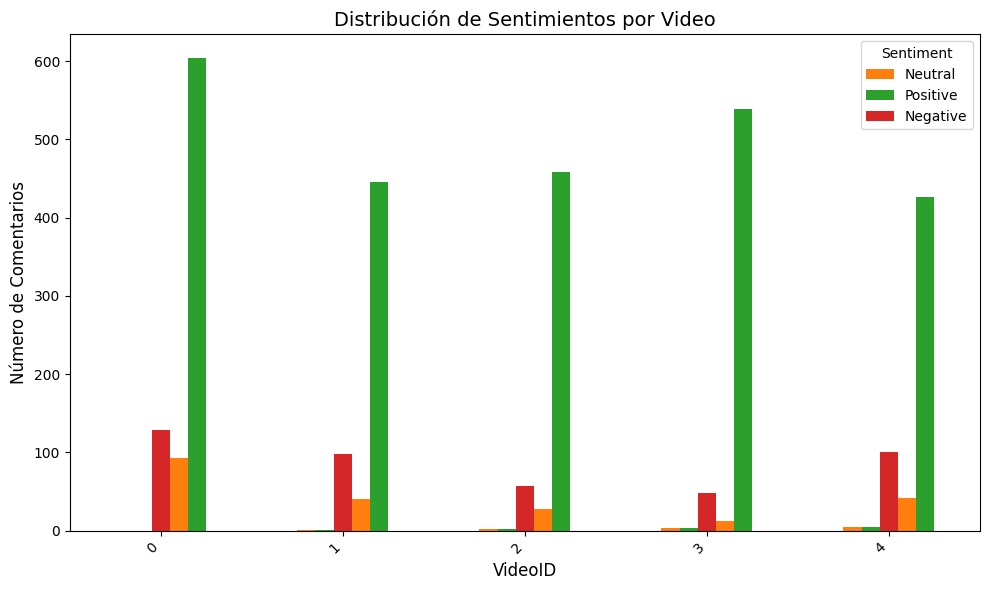

In [ ]:
plt.figure(figsize=(10, 6))

# Graficar los valores
sentiment_summary.plot(kind='bar', stacked=False, color=['#ff7f0e', '#2ca02c', '#d62728'], ax=plt.gca())

# Añadir etiquetas y titulo
plt.title('Distribución de Sentimientos por Video', fontsize=14)
plt.xlabel('VideoID', fontsize=12)
plt.ylabel('Número de Comentarios', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment', labels=['Neutral', 'Positive', 'Negative'])

# Mostrar el grafico
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Crear un DataFrame con los datos relevantes
output_df = top_videos_df[['VideoID', 'Comentario', 'Sentiment']]

# Guardar el DataFrame en un archivo Excel
output_file = "sentimientos_videos.xlsx"
output_df.to_excel(output_file, index=False)

print(f"Archivo guardado exitosamente como '{output_file}'.")


Archivo guardado exitosamente como 'sentimientos_videos.xlsx'.
